In [49]:
from datetime import datetime
import joblib
import pandas as pd
from matplotlib import pyplot as plt
import mlflow
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier

# Exploratory Data Analysis

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [25]:
df = pd.read_csv("./dataset/e2e_lending_club_10k_partitioned.csv")

In [26]:
df.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,mths_since_last_major_derog,policy_code,loan_status,Partition
0,4000,4000,60 months,7.29%,79.76,A,A4,Time Warner Cable,10+ years,MORTGAGE,50000.0,not verified,n,https://www.lendingclub.com/browse/loanDetail....,NaN,medical,Medical,766xx,TX,10.87,0.0,12/1/92,0.0,NaN,NaN,15.0,0.0,12087,12.1,44.0,f,NaN,1,0,T
1,16000,16000,60 months,18.25%,408.48,F,F1,Ottawa University,< 1 year,RENT,39216.0,not verified,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 04/14/11 > I will be using...,debt_consolidation,My Debt Consolidation Loan,660xx,KS,9.15,0.0,11/1/05,2.0,NaN,NaN,4.0,0.0,10114,64.0,5.0,f,NaN,1,0,T
2,8700,8700,36 months,7.88%,272.15,A,A5,Kennedy Wilson,4 years,RENT,65000.0,not verified,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,AP Personal Loan,916xx,CA,11.24,0.0,6/1/70,0.0,NaN,NaN,4.0,0.0,81,0.6,8.0,f,NaN,1,0,T
3,18000,18000,60 months,11.49%,395.78,B,B4,TOWN OF PLATTEKILL,10+ years,MORTGAGE,57500.0,not verified,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt Consolidation Loan,124xx,NY,6.18,1.0,9/1/82,0.0,16.0,NaN,6.0,0.0,10030,37.1,23.0,f,NaN,1,0,T
4,16000,16000,36 months,11.83%,530.15,B,B3,Belmont Correctional,10+ years,MORTGAGE,50004.0,VERIFIED - income,n,https://www.lendingclub.com/browse/loanDetail....,"I want to consolidate my debt, pay for a vacat...",debt_consolidation,consolidate,439xx,OH,19.03,0.0,10/1/99,4.0,NaN,NaN,8.0,0.0,10740,40.4,21.0,f,NaN,1,0,T


In [27]:
df.describe()

,loan_amnt,funded_amnt,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,mths_since_last_major_derog,policy_code,loan_status
count,10000.000000,10000.000000,10000.00000,9999.000000,10000.000000,9995.000000,9995.000000,3684.000000,840.000000,9995.000000,9995.000000,1.000000e+04,9977.000000,9995.000000,0.0,10000.0,10000.000000
mean,11035.522500,10765.972500,321.43098,68203.011539,13.338704,0.148174,1.066933,35.890337,61.652381,9.334567,0.060130,1.427101e+04,48.467474,22.089645,NaN,1.0,0.129500
std,7468.121308,7192.633069,210.62291,48590.252757,6.754212,0.506270,1.476052,22.361443,46.189619,4.526590,0.251245,2.543791e+04,28.232809,11.622152,NaN,0.0,0.335769
min,500.000000,500.000000,15.69000,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,1.000000,NaN,1.0,0.000000
25%,5000.000000,5000.000000,163.47000,40000.000000,8.160000,0.000000,0.000000,18.000000,0.000000,6.000000,0.000000,3.524500e+03,25.000000,13.000000,NaN,1.0,0.000000
50%,9600.000000,9250.000000,275.11000,58000.000000,13.410000,0.000000,1.000000,34.000000,86.000000,9.000000,0.000000,8.645500e+03,48.700000,20.000000,NaN,1.0,0.000000
75%,15000.000000,15000.000000,427.03750,82000.000000,18.692500,0.000000,2.000000,53.000000,101.000000,12.000000,0.000000,1.695225e+04,71.900000,29.000000,NaN,1.0,0.000000
max,35000.000000,35000.000000,1276.60000,900000.000000,29.990000,11.000000,25.000000,120.000000,119.000000,39.000000,3.000000,1.207359e+06,108.800000,90.000000,NaN,1.0,1.000000


In [28]:
df.shape

(10000, 35)

In [32]:
df['url'] = df['url'].astype('string')
df['desc'] = df['desc'].astype('string')
df['loan_status'] = df['loan_status'].astype('category')

In [33]:
df.dtypes

loan_amnt                         int64
funded_amnt                       int64
term                             object
int_rate                         object
installment                     float64
grade                            object
sub_grade                        object
emp_title                        object
emp_length                       object
home_ownership                   object
annual_inc                      float64
verification_status              object
pymnt_plan                       object
url                              string
desc                             string
purpose                          object
title                            object
zip_code                         object
addr_state                       object
dti                             float64
delinq_2yrs                     float64
earliest_cr_line                 object
inq_last_6mths                  float64
mths_since_last_delinq          float64
mths_since_last_record          float64


# Feature Transformation

In [34]:
numeric_transform = SimpleImputer(strategy='constant', fill_value=0)
categoric_tranform = Pipeline(
    steps=[
        ('null_imputation', SimpleImputer(strategy='constant', fill_value='UNKNOWN')),
        ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ]
)

In [35]:
# Col transfomer automatically handles right cols via datatypes
col_transformer = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transform, make_column_selector(dtype_include=[float,int])),
        ('categoric', categoric_tranform, make_column_selector(dtype_include=object))
    ]
)

# Partitioning

In [37]:
training_data = df[df['Partition'] == "T"].drop(labels=['Partition'], axis=1)

In [38]:
training_data.shape

(6400, 34)

In [40]:
validation_data = df[df['Partition'] == "V"].drop(labels=['Partition'], axis=1)

In [41]:
validation_data.shape

(1600, 34)

In [42]:
X_train = training_data.drop(labels='loan_status', axis=1)
y_train = training_data['loan_status']
X_val = validation_data.drop(labels='loan_status', axis=1)
y_val = validation_data['loan_status']

# Set up MLflow for Experiment Tracking

In [14]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment(experiment_name="kaggle_lending_club_xgboost")

<Experiment: artifact_location='mlflow-artifacts:/379835271244432248', creation_time=1675537719388, experiment_id='379835271244432248', last_update_time=1675537719388, lifecycle_stage='active', name='kaggle_lending_club_xgboost', tags={}>

In [15]:
mlflow.xgboost.autolog()

In [16]:
my_run_id = datetime.today().strftime('%Y-%m-%d_%H:%M:%S')
my_run_name="demo" + " " + my_run_id
run = mlflow.start_run(run_name=my_run_name)

In [17]:
mlflow.set_tag("Use Case Owner", "Dan Esposito")
mlflow.set_tag("Data Scientist", "Zhilei Ma")

# Model Training & Evalution

In [50]:
xgb_model = XGBClassifier(
    learning_rate=.1,
    n_estimators=100,
    objective="binary:logistic",
    eval_metric=["logloss"],
    early_stopping_rounds=10,
    verbose=True
)

In [51]:
# Creates the model pipeline object:
model = Pipeline(
    steps=[
        ('col_transformer', col_transformer),
        ('model', xgb_model)
    ]
)

In [52]:
model[:-1].fit(X_train)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x13ae3cf10>),
                                                 ('categoric',
                                                  Pipeline(steps=[('null_imputation',
                                                                   SimpleImputer(fill_value='UNKNOWN',
                                                                                 strategy='constant')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                              

In [53]:
X_val = model[:-1].transform(X_val)

In [54]:
model.fit(
    X_train, 
    y_train, 
    model__eval_set=[(X_val, y_val)]
)

[16:48:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-logloss:0.63953
[1]	validation_0-logloss:0.60007
[2]	validation_0-logloss:0.56439
[3]	validation_0-logloss:0.53543
[4]	validation_0-logloss:0.51101
[5]	validation_0-logloss:0.49954
[6]	validation_0-logloss:0.48170
[7]	validation_0-logloss:0.47235
[8]	validation_0-logloss:0.46104
[9]	validation_0-logloss:0.44928
[10]	validation_0-logloss:0.44428
[11]	validation_0-logloss:0.43730
[12]	validation_0-logloss:0.42820
[13]	validation_0-logloss:0.42320
[14]	validation_0-logloss:0.41836
[15]	validation_0-logloss:0.41247
[16]	validation_0-logloss:0.40747
[17]	validation_0-logloss:0.40338
[18]	validation_0-logloss:0.40091
[19]	validation_0-logloss:0.39694
[20]	validation_0-logloss:0.39480
[21]	validation_0-logloss:0.39330
[22]	validation_0-logloss:0.39104
[23]	validation_0-logloss:0.38991
[24]	validati

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x13ae3cf10>),
                                                 ('categoric',
                                                  Pipeline(steps=[('null_imputation',
                                                                   SimpleImputer(fill_value='UNKNOWN',
                                                                                 strategy='constant')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder(handle...
                               eval_metric=['logloss'], feature_types=No

In [55]:
eval_results = model.named_steps['model'].evals_result()

# Log The Learning Curve in MLflow

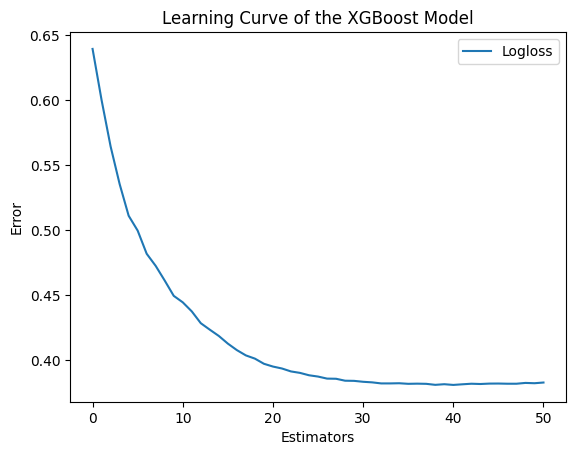

In [56]:
plt.plot(eval_results['validation_0']['logloss'], label='logloss')
plt.xlabel('Estimators')
plt.ylabel('Error')
plt.title('Learning Curve of the XGBoost Model')
plt.legend(['Logloss'])


# save the figure
plt.savefig('./artifact/learning_curve.png', dpi=300, bbox_inches='tight')


plt.show()

In [57]:
# Log the plotted learning curve in MLflow 
mlflow.log_artifact("./artifact/learning_curve.png")

# Serialization

In [58]:
# Serialize and save the trained model
joblib.dump(model, "model.pkl")

['model.pkl']

# Test & Validate Locally

In [1]:
!drum score -cd . --input ./dataset/demo_lending_club_scoring_10k.csv \
--target-type binary --positive-class-label 1 --negative-class-label 0 \
--verbose

pyenv: drum: command not found

The `drum' command exists in these Python versions:
  3.9.7

Note: See 'pyenv help global' for tips on allowing both
      python2 and python3 to be found.


In [28]:
!drum validation  --code-dir . --input ./dataset/demo_lending_club_scoring_10k.csv \
--target-type binary --positive-class-label 1 --negative-class-label 0



Validation checks results
      Test case          Status   Details
Basic batch prediction   PASSED          
Null value imputation    PASSED          


In [29]:
!drum --help

usage: drum [-h] [--version]
            {score,fit,perf-test,validation,server,new,push} ...

Run user model

positional arguments:
  {score,fit,perf-test,validation,server,new,push}
                        Commands
    score               Run predictions in batch mode
    fit                 Fit your model to your data
    perf-test           Run performance tests
    validation          Run validation checks against the model
    server              serve the model via REST APIs
    new                 Create new model/env template
    push                Add your modeling code into DataRobot

optional arguments:
  -h, --help            show this help message and exit
  --version             show program's version number and exit
